In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!apt-get install openjdk-8-jdk -qq> /dev/null

# Download Apache Spark
!wget https://dlcdn.apache.org/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz

# Extract the downloaded archive
!tar xf spark-3.4.1-bin-hadoop3.tgz

# specify where the files are
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

!pip install -q findspark
import findspark

findspark.init()

from pyspark.sql.functions import col

import pyspark
from pyspark import SparkContext

# Create a local SparkContext
sc = SparkContext('local', 'MyApp')

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local(*)").getOrCreate()

#spark.conf.set("spark.sqk.repl.eagerEval.enables", True)

spark

--2023-08-26 12:23:09--  https://dlcdn.apache.org/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388341449 (370M) [application/x-gzip]
Saving to: ‘spark-3.4.1-bin-hadoop3.tgz’

spark-3.4.1-bin-had 100%[===================>] 370.35M   231MB/s    in 1.6s    

2023-08-26 12:23:11 (231 MB/s) - ‘spark-3.4.1-bin-hadoop3.tgz’ saved [388341449/388341449]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
raw_df = spark.read.csv('/content/drive/MyDrive/Data Analytics/housdata.csv', header=True, inferSchema=True)
raw_df.show()

+--------------+----+------+---+------+------+-----+----+-----+-----+-----+-----+-----+------+----+-------+------+-------+------+------+------+-----+-----+-----+-----------+-------------+-------+-----------+-----------+-----------+-----------+-----------+-----------+------+--------+-----+-----+-----+-----+--------+-----------+-----------+-----------+--------+-----------+------------+------------+------------+------------+------------+------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+----------------+----------------+----------------+--------------------+--------------+-----------+-----------------+---------+----------+--------------------+--------------------+--------------------+---------

# Data Cleaning
1. Create new df containing only the chosen columns

In [ ]:
df = raw_df[['AGE1','TENURE', 'FMTOWNRENT', 'BEDRMS', 'PER', 'ROOMS', 'NUNITS', 'OTHERCOST', 'ZINC2', 'BUILT', 'BURDEN', 'UTILITY', 'TOTSAL', 'STRUCTURETYPE', 'REGION', 'LMED', 'FMR', 'VALUE', 'VACANCY', 'ZADEQ']]
df.show()

+----+------+----------+------+---+-----+------+-----------+------+-----+-----------+-----------+------+-------------+------+-----+----+------+-------+-----+
|AGE1|TENURE|FMTOWNRENT|BEDRMS|PER|ROOMS|NUNITS|  OTHERCOST| ZINC2|BUILT|     BURDEN|    UTILITY|TOTSAL|STRUCTURETYPE|REGION| LMED| FMR| VALUE|VACANCY|ZADEQ|
+----+------+----------+------+---+-----+------+-----------+------+-----+-----------+-----------+------+-------------+------+-----+----+------+-------+-----+
|  87|   '1'| '1 Owner'|     3|  2|    6|     1|      310.0| 65250| 2006|0.109241379|229.1666667|     0|            1|   '1'|71779|1095| 50000|     -6|  '1'|
|  70|   '1'| '1 Owner'|     3|  1|    5|     1|     222.75| 35400| 2006|0.231864407|355.4166667|     0|            1|   '1'|71779|1095|238000|     -6|  '1'|
|  48|   '1'| '1 Owner'|     4|  4|    6|     1|79.16666667| 74932| 1985|0.248064912|      199.0| 58932|            1|   '3'|53872| 965|200000|     -6|  '1'|
|  62|   '1'| '1 Owner'|     3|  2|    6|     1|    

## Check for Duplicates

In [ ]:
duplicated_count = df.groupBy(df.columns).count().where(col("count") > 1).count()

print("There are {} duplicated rows in the dataset.".format(duplicated_count))
print("Number of rows before dropping duplicates is {}.".format(df.count()))

# Drop duplicates and keep the first occurrence
df = df.dropDuplicates()

print("Number of rows after dropping duplicates is {}.".format(df.count()))


There are 19 duplicated rows in the dataset.
Number of rows before dropping duplicates is 49090.
Number of rows after dropping duplicates is 49068.


In [ ]:
df.describe().show()

+-------+------------------+------+----------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+------+------------------+------------------+-----------------+------------------+-----+
|summary|              AGE1|TENURE|FMTOWNRENT|           BEDRMS|               PER|            ROOMS|            NUNITS|         OTHERCOST|            ZINC2|             BUILT|           BURDEN|           UTILITY|           TOTSAL|     STRUCTURETYPE|REGION|              LMED|               FMR|            VALUE|           VACANCY|ZADEQ|
+-------+------------------+------+----------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+------+------------------+------------------+-----------------+---------

# Data Analysis

<font color="lightgreen"><h1> 1. How many percentage are renter and owners in the whole dataset?</h1></font>

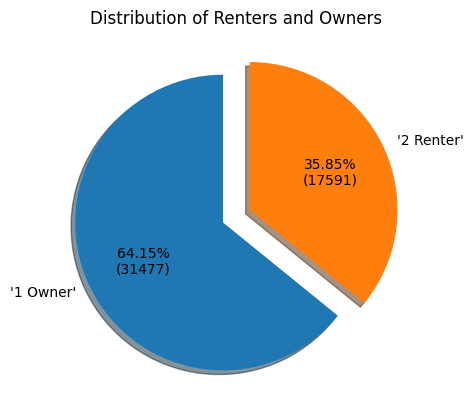

In [ ]:
# Convert the Spark DataFrame to a Pandas DataFrame
pd_df1 = df.toPandas()

value_counts = pd_df1['FMTOWNRENT'].value_counts()

# Create a pie chart
plt.figure()
plt.pie(value_counts, labels=value_counts.index, explode=(0.1, 0.1), shadow=True, startangle=90, autopct=lambda p: '{:.2f}%\n({:.0f})'.format(p, p * sum(value_counts) / 100))

# Add a title to the chart
plt.title("Distribution of Renters and Owners")

# Show the pie chart
plt.show()


The majority of the dataset owned a house.


<font color="lightgreen"><h1> 2. How many renters/owners based on their social class</h1></font>

An income quintile is a measure of neighbourhood socioeconomic status that divides the population into 5 income groups (from lowest income to highest income) so that approximately 20% of the population is in each group.
So, we are taking the Household Income Distribution (HIQ) in the year 2009 as our dataset are from 1985-2009.
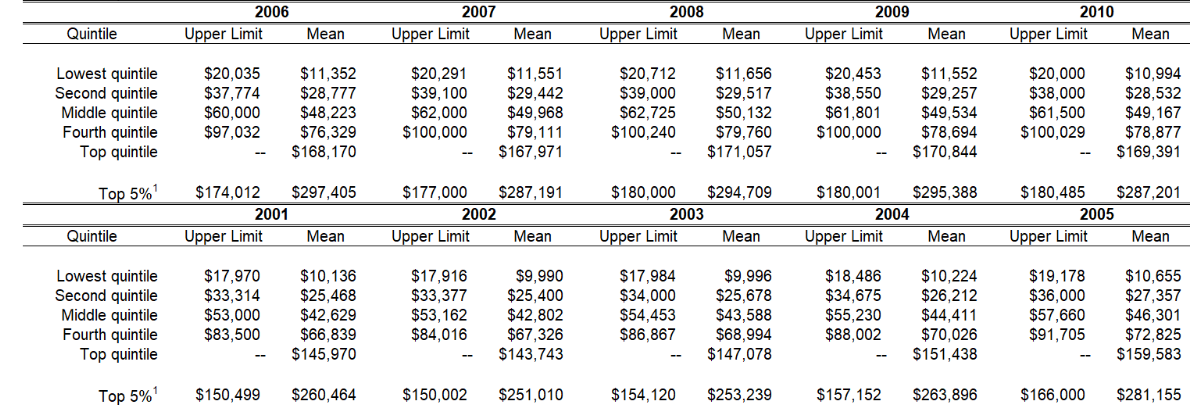

So, the division in as below
1. Lowest Quintile <20,034
2. 20,035 < Second Quintile < 38,549
3. 38,550 < Middle Quintile < 61,800
4. 61,801 < Fourth Quintile < 100,000
5. 100,001 < Top Quintile < 180,001

6. Top 5% > 180,001


> Variables used
  - Income = ZINC2
  - Tenure = FMTOWNRENT

In [ ]:
df2 = df[['ZINC2', 'FMTOWNRENT']]
df2.show()

+------+----------+
| ZINC2|FMTOWNRENT|
+------+----------+
| 70000|'2 Renter'|
| 20000| '1 Owner'|
|  6500|'2 Renter'|
|119000| '1 Owner'|
| 79900| '1 Owner'|
| 33000| '1 Owner'|
|108000| '1 Owner'|
| 16540| '1 Owner'|
|    -6|'2 Renter'|
| 32400| '1 Owner'|
|101000| '1 Owner'|
|    -6|'2 Renter'|
| 96900| '1 Owner'|
| 23800|'2 Renter'|
| 55000|'2 Renter'|
|    -6|'2 Renter'|
|100000| '1 Owner'|
| 54900|'2 Renter'|
| 55000|'2 Renter'|
| 30000|'2 Renter'|
+------+----------+
only showing top 20 rows



In [ ]:
# Filter out rows with ZINC2 less than
df2 = df2.filter(df2['ZINC2'] > 0)
df2.describe().show()


+-------+-----------------+----------+
|summary|            ZINC2|FMTOWNRENT|
+-------+-----------------+----------+
|  count|            44284|     44284|
|   mean| 66996.3812663716|      null|
| stddev|68426.17762646428|      null|
|    min|                1| '1 Owner'|
|    max|           852840|'2 Renter'|
+-------+-----------------+----------+



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Define the income ranges
income_ranges = [0, 20034, 38549, 61800, 100000, 180001, float('inf')]
income_range_labels = ['Lowest', 'Second', 'Middle', 'Fourth', 'Top 5%']

# Use the 'withColumn' function to add a new column with income ranges
df2 = df2.withColumn(
    'Quintile',
    when((col('ZINC2') >= income_ranges[0]) & (col('ZINC2') < income_ranges[1]), income_range_labels[0])
    .when((col('ZINC2') >= income_ranges[1]) & (col('ZINC2') < income_ranges[2]), income_range_labels[1])
    .when((col('ZINC2') >= income_ranges[2]) & (col('ZINC2') < income_ranges[3]), income_range_labels[2])
    .when((col('ZINC2') >= income_ranges[3]) & (col('ZINC2') < income_ranges[4]), income_range_labels[3])
    .when(col('ZINC2') >= income_ranges[4], income_range_labels[4])
    .otherwise('Unknown')
)

df2.show()

+------+----------+--------+
| ZINC2|FMTOWNRENT|Quintile|
+------+----------+--------+
| 70000|'2 Renter'|  Fourth|
| 20000| '1 Owner'|  Lowest|
|  6500|'2 Renter'|  Lowest|
|119000| '1 Owner'|  Top 5%|
| 79900| '1 Owner'|  Fourth|
| 33000| '1 Owner'|  Second|
|108000| '1 Owner'|  Top 5%|
| 16540| '1 Owner'|  Lowest|
| 32400| '1 Owner'|  Second|
|101000| '1 Owner'|  Top 5%|
| 96900| '1 Owner'|  Fourth|
| 23800|'2 Renter'|  Second|
| 55000|'2 Renter'|  Middle|
|100000| '1 Owner'|  Top 5%|
| 54900|'2 Renter'|  Middle|
| 55000|'2 Renter'|  Middle|
| 30000|'2 Renter'|  Second|
|100000| '1 Owner'|  Top 5%|
| 82000| '1 Owner'|  Fourth|
| 74200| '1 Owner'|  Fourth|
+------+----------+--------+
only showing top 20 rows



In [ ]:
# Drop a column
df2 = df2.drop('ZINC2')
df2.show()

+----------+--------+
|FMTOWNRENT|Quintile|
+----------+--------+
|'2 Renter'|  Fourth|
| '1 Owner'|  Lowest|
|'2 Renter'|  Lowest|
| '1 Owner'|  Top 5%|
| '1 Owner'|  Fourth|
| '1 Owner'|  Second|
| '1 Owner'|  Top 5%|
| '1 Owner'|  Lowest|
| '1 Owner'|  Second|
| '1 Owner'|  Top 5%|
| '1 Owner'|  Fourth|
|'2 Renter'|  Second|
|'2 Renter'|  Middle|
| '1 Owner'|  Top 5%|
|'2 Renter'|  Middle|
|'2 Renter'|  Middle|
|'2 Renter'|  Second|
| '1 Owner'|  Top 5%|
| '1 Owner'|  Fourth|
| '1 Owner'|  Fourth|
+----------+--------+
only showing top 20 rows



In [ ]:
# Get unique values from the 'FMTOWNRENT' column
unique_fmtownrent_values = df2.select('FMTOWNRENT').distinct().rdd.flatMap(lambda x: x).collect()
print(unique_fmtownrent_values)


["'2 Renter'", "'1 Owner'"]


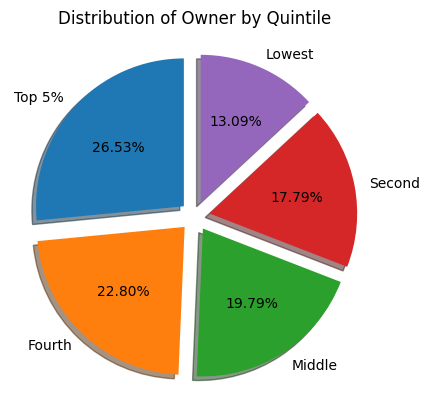

In [ ]:
# Convert the Spark DataFrame to a Pandas DataFrame
pd_df2 = df2.toPandas()

# Filter the DataFrame to rows where 'FMTOWNRENT' is '1 Owner'
owner_df = pd_df2[pd_df2['FMTOWNRENT'] == "'1 Owner'"]

# Calculate the value counts for each unique value in the 'Quintile' column within '1 Owner' rows
owner_counts = owner_df['Quintile'].value_counts()

# Create a pie chart
plt.figure()
plt.pie(owner_counts, labels=owner_counts.index, shadow=True, startangle=90, autopct='%1.2f%%', explode=(0.1, 0.1, 0.1, 0.1, 0.1))

# Add a title to the chart
plt.title("Distribution of Owner by Quintile")

# Show the pie chart
plt.show()

About half of the owners are the fourth quintile and top 5%. This may be due to for rich people, property can be seen as an investment rather than their home.

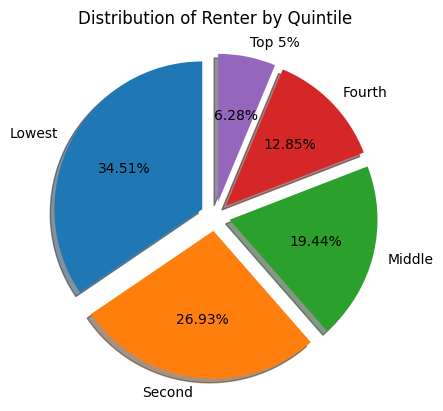

In [ ]:
# Convert the Spark DataFrame to a Pandas DataFrame
pd_df2 = df2.toPandas()

# Filter the DataFrame to rows where 'FMTOWNRENT' is '1 Owner'
renter_df = pd_df2[pd_df2['FMTOWNRENT'] == "'2 Renter'"]

# Calculate the value counts for each unique value in the 'Quintile' column within '1 Owner' rows
renter_counts = renter_df['Quintile'].value_counts()

# Create a pie chart
plt.figure()
plt.pie(renter_counts, labels=renter_counts.index, shadow=True, startangle=90, autopct='%1.2f%%', explode=(0.1, 0.1, 0.1, 0.1, 0.1))

# Add a title to the chart
plt.title("Distribution of Renter by Quintile")

# Show the pie chart
plt.show()

The Lowest & Second quintile dominates the rent's market by 2/3 of the data. This can be due to their low income makes it hard  for them to buy a house (loan approval, house value, etc)

<font color="lightgreen"><h1> 3. Do people with higher income have higher house value? (for both owner & renter)</h1></font>
> Variables
  - Income (ZINC2)
  - House Value (VALUE)

In [ ]:
df3 = df[['ZINC2', 'VALUE']]
df3.describe().show()

+-------+-----------------+-----------------+
|summary|            ZINC2|            VALUE|
+-------+-----------------+-----------------+
|  count|            49068|            49068|
|   mean|60460.54775006114|158074.6332029021|
| stddev|67978.78827433457|250180.8188612107|
|    min|           -26976|               -6|
|    max|           852840|          2465647|
+-------+-----------------+-----------------+



In [ ]:
# filter out income & house value less than zero
df3 = df3.filter(df3['ZINC2'] > 0)
df3 = df3.filter(df3['VALUE'] > 0)

df3.describe().show()

+-------+-----------------+------------------+
|summary|            ZINC2|             VALUE|
+-------+-----------------+------------------+
|  count|            29905|             29905|
|   mean|79935.88426684501|246742.25326868417|
| stddev|75184.06437858166| 273220.8036223053|
|    min|                1|                 1|
|    max|           852840|           2465647|
+-------+-----------------+------------------+



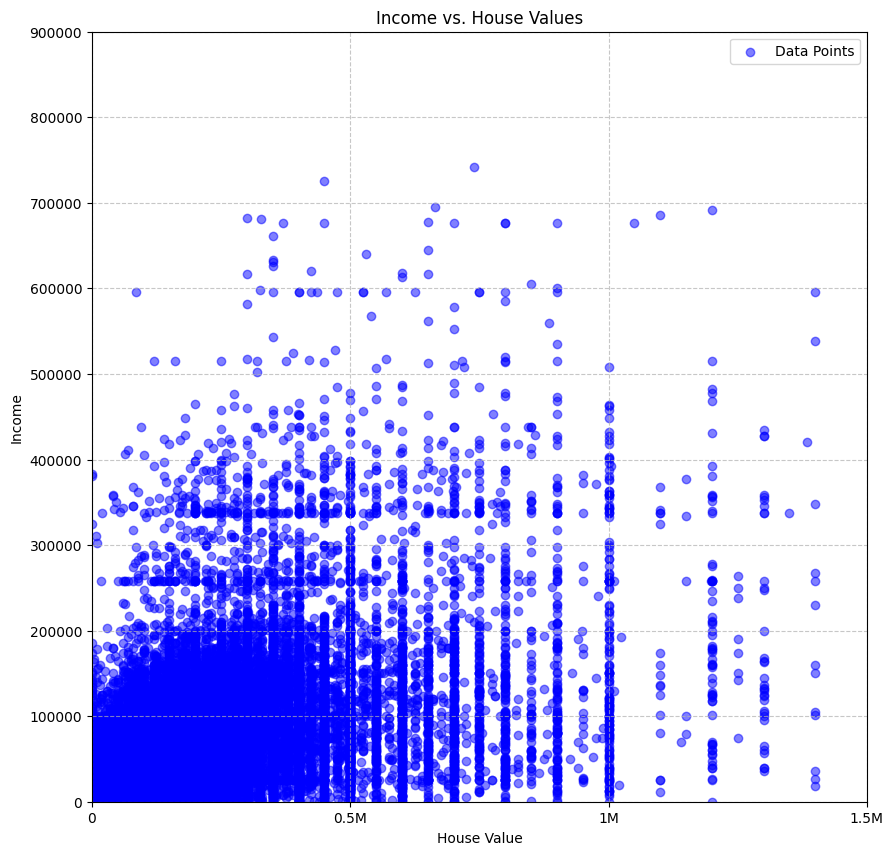

In [ ]:
pd_df3 = df3.toPandas()


plt.figure(figsize=(10, 10))

# Scatter plot with enhanced visual features
plt.scatter(x=pd_df3['VALUE'], y=pd_df3['ZINC2'], color='blue', alpha=0.5, label='Data Points')
plt.title('Income vs. House Values')
plt.xlabel('House Value')
plt.ylabel('Income')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Limit axes range if needed
plt.xlim(0, 150000)  # Adjust the values as necessary
plt.ylim(0, 900000)   # Adjust the values as necessary

# Set custom x-axis tick locations and labels
custom_xticks = [0, 500000, 1000000, 1500000]
custom_xtick_labels = ['0', '0.5M', '1M', '1.5M']
plt.xticks(custom_xticks, custom_xtick_labels)

# Display the plot
plt.show()


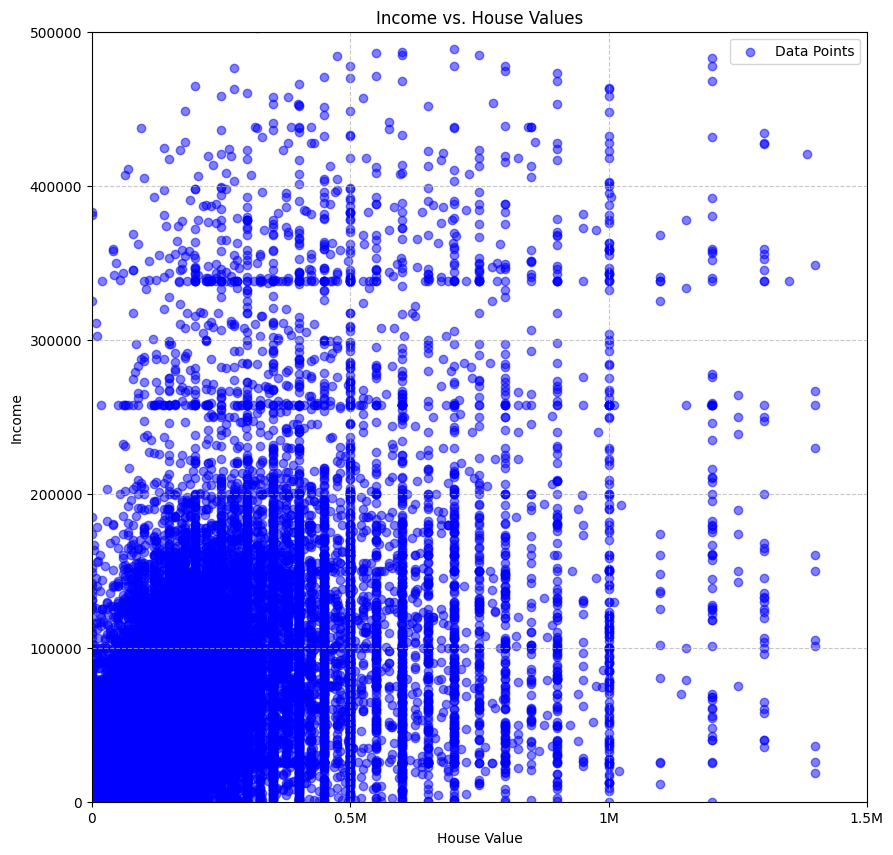

In [ ]:
plt.figure(figsize=(10, 10))

# Scatter plot with enhanced visual features
plt.scatter(x=pd_df3['VALUE'], y=pd_df3['ZINC2'], color='blue', alpha=0.5, label='Data Points')
plt.title('Income vs. House Values')
plt.xlabel('House Value')
plt.ylabel('Income')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Limit axes range if needed
plt.xlim(0, 150000)  # Adjust the values as necessary
plt.ylim(0, 500000)   # Adjust the values as necessary

# Set custom x-axis tick locations and labels
custom_xticks = [0, 500000, 1000000, 1500000]
custom_xtick_labels = ['0', '0.5M', '1M', '1.5M']
plt.xticks(custom_xticks, custom_xtick_labels)

# Display the plot
plt.show()


<font color="lightgreen"><h1> 4. Do number of people in a household increase as the age of the head of a household increase?</h1></font>

> Variables
  - No of people in a household = PER
  - Age of the headof household = AGE1

In [ ]:
df4 = df[['PER', 'AGE1']]
df4.describe().show()

+-------+------------------+------------------+
|summary|               PER|              AGE1|
+-------+------------------+------------------+
|  count|             49068|             49068|
|   mean|1.8160104344990626| 46.00014265916687|
| stddev|2.7164447967521523|23.310777795787647|
|    min|                -6|                -9|
|    max|                14|                93|
+-------+------------------+------------------+



In [ ]:
# Filter negative data

df4 = df4.filter(df4['PER'] > 0)
df4 = df4.filter(df4['AGE1']> 0)

df4.describe().show()

+-------+------------------+------------------+
|summary|               PER|              AGE1|
+-------+------------------+------------------+
|  count|             45057|             45057|
|   mean|2.5117961692966686|50.896286925449985|
| stddev|1.4537738374258677|17.277128359384527|
|    min|                 1|                14|
|    max|                14|                93|
+-------+------------------+------------------+



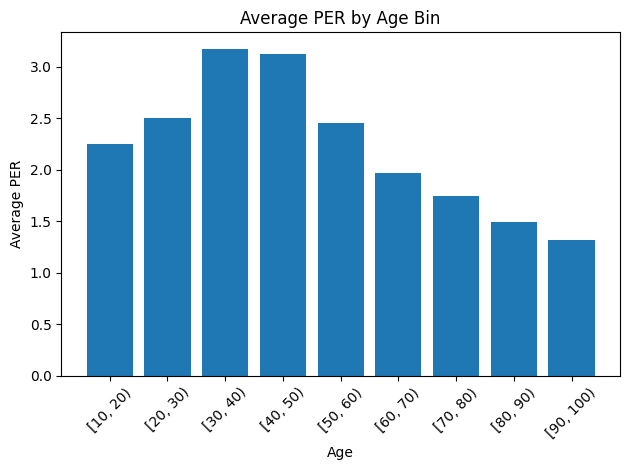

In [ ]:
pd_df4 = df4.toPandas()
# Create age bins (you can adjust the bin size as needed)
bin_size = 10
age_bins = np.arange(0, pd_df4['AGE1'].max() + bin_size, bin_size)

# Cut 'AGE1' values into bins
pd_df4['AgeBin'] = pd.cut(pd_df4['AGE1'], bins=age_bins, right=False)

# Group by 'AgeBin' and calculate the mean 'PER' for each bin
age_per_mean = pd_df4.groupby('AgeBin')['PER'].mean()

# Create a bar graph
plt.bar(age_per_mean.index.astype(str), age_per_mean)
plt.title('Average PER by Age Bin')
plt.xlabel('Age')
plt.ylabel('Average PER')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the bar graph
plt.show()


As the head of the household increases, the number of people in a household increase. This can be largely due to they having kids during that age and after 50, most of their kids will move out of their home hence the decreasing number of Average people in a household.

<font color="lightgreen"><h1>5. Do older people prefer single unit or building with multiple units?</h1></font>

> Variables
  - Units = STRUCTURETYPE
  - Older people = AGE1

In [ ]:
df5 = df[['AGE1', 'STRUCTURETYPE']]
df5.describe().show()

+-------+------------------+------------------+
|summary|              AGE1|     STRUCTURETYPE|
+-------+------------------+------------------+
|  count|             49068|             49068|
|   mean| 46.00014265916687| 1.819821472242602|
| stddev|23.310777795787647|1.4424372779554488|
|    min|                -9|                -9|
|    max|                93|                 6|
+-------+------------------+------------------+



In [ ]:

df5 = df5.filter(df5['AGE1'] > 60)
df5 = df5.withColumn('STRUCTURETYPE', when(col('STRUCTURETYPE') == 1, col('STRUCTURETYPE')).otherwise(2))

df5.describe().show()

+-------+-----------------+------------------+
|summary|             AGE1|     STRUCTURETYPE|
+-------+-----------------+------------------+
|  count|            12974|             12974|
|   mean|72.54208416833667|1.2619855094804995|
| stddev|8.653217421555254|0.4397317435266575|
|    min|               61|                 1|
|    max|               93|                 2|
+-------+-----------------+------------------+



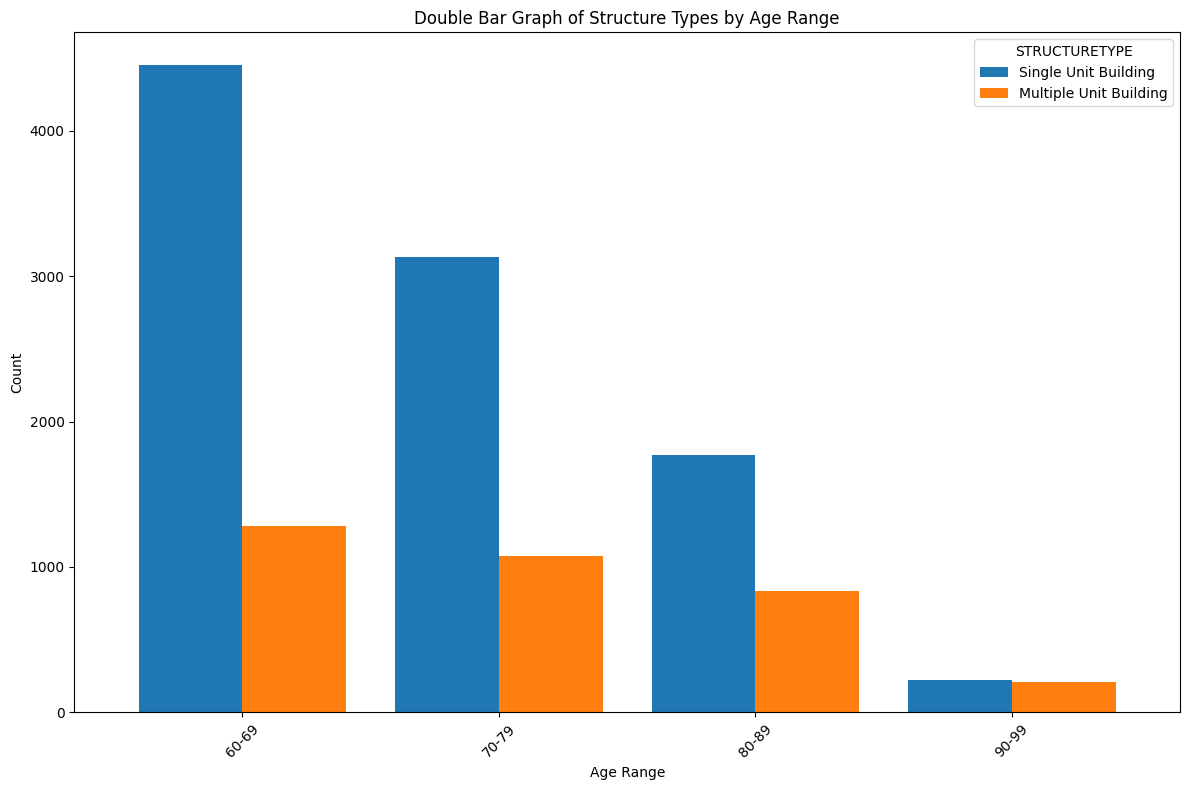

In [ ]:
pd_df5 = df5.toPandas()
# Define age ranges
age_bins = np.arange(60, 101, 10)
age_labels = [f'{start}-{end-1}' for start, end in zip(age_bins, age_bins + 10)]

# Cut 'AGE1' values into age ranges
pd_df5['AgeRange'] = pd.cut(pd_df5['AGE1'], bins=age_bins, labels=age_labels[:-1], right=False)

# Group by 'AgeRange' and 'STRUCTURETYPE', and calculate value counts
age_structure_counts = pd_df5.groupby(['AgeRange', 'STRUCTURETYPE']).size().unstack()

# Create a double bar graph
ax = age_structure_counts.plot(kind='bar', stacked=False, figsize=(12, 8), width=0.81)
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.title('Double Bar Graph of Structure Types by Age Range')
plt.legend(title='STRUCTURETYPE', labels=['Single Unit Building', 'Multiple Unit Building'])

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


For a while, older people until the age of 80 prefer to live alone. But when they are 90 and above, they tend to live in a community. This can be due to their family encourage them not to live alone because it is hard for them to know if anything happen to their parents

<font color="lightgreen"><h1>6. Do ZADEQ affect the value of the house and Fair Market Rent?</h1></font>

According to [American Housing Survey](https://www.huduser.gov/publications/pdf/ahs_hsg.pdf), The Adequacy Index (named ZADEQ prior to the 2015 AHS) is comprised of eight criterion capturing severe physical deficiencies like no running water, plumbing, etc. US Department of Housing and Urban Development (HUD) created this measure to assess the extent to which the  housing stock met the standard of “a decent home and a suitable living environment,”

The HUD measure is contained in the variable ZADEQ, which
takes three values:
- 1 if a unit is considered adequate,
- 2 if a unit is considered moderately inadequate, and
- 3 if a unit is considered severely inadequate

> Variables
  - Adequecy Index = ZADEQ
  - Value = VALUE, FMR

In [ ]:
df6 = df[['ZADEQ', 'VALUE', 'FMR']]
df6.describe().show()

+-------+-----+-----------------+------------------+
|summary|ZADEQ|            VALUE|               FMR|
+-------+-----+-----------------+------------------+
|  count|49068|            49068|             49068|
|   mean| null|158074.6332029021|1073.1411714355588|
| stddev| null|250180.8188612107|355.65992591671267|
|    min| '-6'|               -6|               427|
|    max|  '3'|          2465647|              3501|
+-------+-----+-----------------+------------------+



In [ ]:
print("Number of rows before filtering:", df6.count())
# Filter out rows with ZADEQ values less than 0
df6 = df6.filter(df6['ZADEQ'] != "'-6'")
print("Number of rows after filtering:", df6.count())
# Show the resulting DataFrame
df6.describe().show()


Number of rows before filtering: 49068
Number of rows after filtering: 45057
+-------+-----+------------------+------------------+
|summary|ZADEQ|             VALUE|               FMR|
+-------+-----+------------------+------------------+
|  count|45057|             45057|             45057|
|   mean| null| 165356.5500366203|1083.2290654060412|
| stddev| null|252187.55376145715|357.53157953189094|
|    min|  '1'|                -6|               427|
|    max|  '3'|           2465647|              3501|
+-------+-----+------------------+------------------+



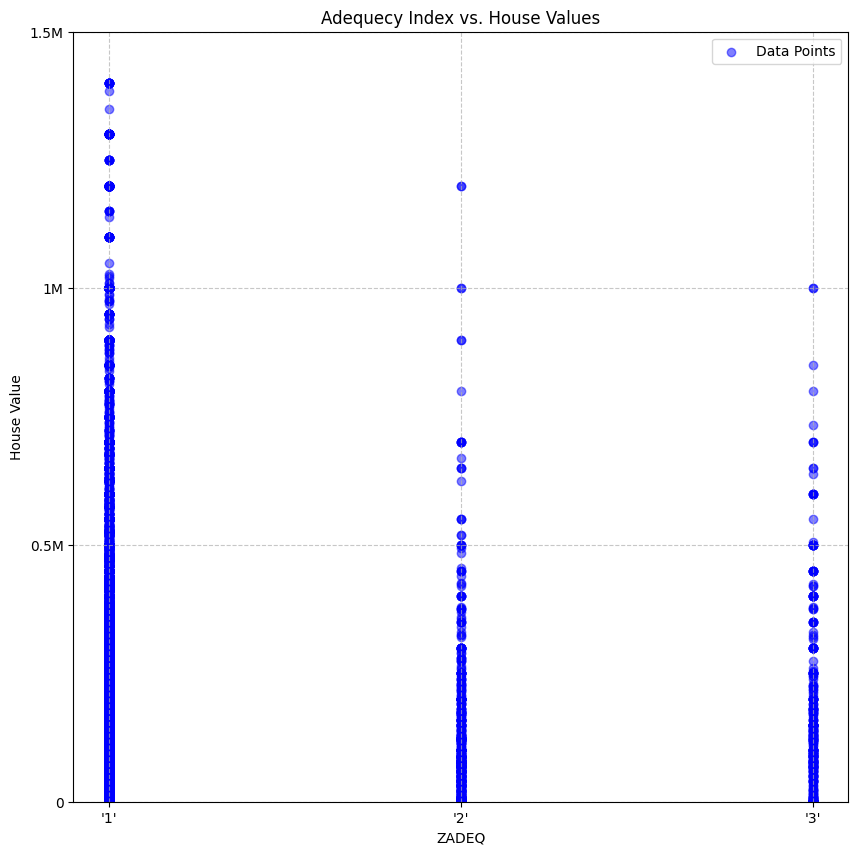

In [ ]:
plt.figure(figsize=(10, 10))
pd_df6 = df6.toPandas()

# Scatter plot with enhanced visual features
plt.scatter(x=pd_df6['ZADEQ'], y=pd_df6['VALUE'], color='blue', alpha=0.5, label='Data Points')
plt.title('Adequecy Index vs. House Values')
plt.xlabel('ZADEQ')
plt.ylabel('House Value')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()


# Limit axes range if needed
plt.ylim(0, 500000)   # Adjust the values as necessary

# Set custom x-axis tick locations and labels
custom_yticks = [0, 500000, 1000000, 1500000]
custom_ytick_labels = ['0', '0.5M', '1M', '1.5M']
plt.yticks(custom_yticks, custom_ytick_labels)

# Display the plot
plt.show()


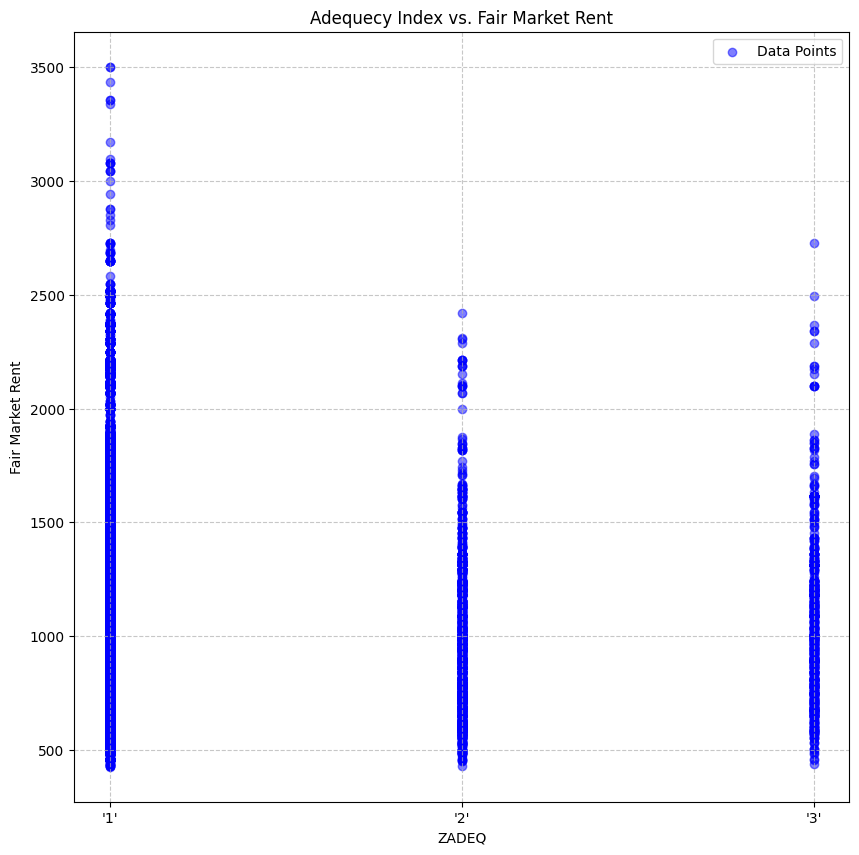

In [ ]:
plt.figure(figsize=(10, 10))
pd_df6 = df6.toPandas()

# Scatter plot with enhanced visual features
plt.scatter(x=pd_df6['ZADEQ'], y=pd_df6['FMR'], color='blue', alpha=0.5, label='Data Points')
plt.title('Adequecy Index vs. Fair Market Rent')
plt.xlabel('ZADEQ')
plt.ylabel('Fair Market Rent')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()


# Limit axes range if needed
#plt.ylim(0, 500000)   # Adjust the values as necessary

# Set custom x-axis tick locations and labels
#custom_yticks = [0, 500000, 1000000, 1500000]
#custom_ytick_labels = ['0', '0.5M', '1M', '1.5M']
#plt.yticks(custom_yticks, custom_ytick_labels)

# Display the plot
plt.show()


Both the value and Fair Market Rent are higher if the score fo Adequecy Index is high. This can be due to people not wanting to live in an inadequate house wihch drive the value down due to poor demand/

<font color="lightgreen"><h1>7. Do median income in an area affect what type of home structure that they built?</h1></font>

> Variables
  - Area median income = LMED
  - Home structure = STRUCTURETYPE

In [ ]:
df7 = df[['LMED', 'STRUCTURETYPE']]
df7.describe().show()

+-------+------------------+------------------+
|summary|              LMED|     STRUCTURETYPE|
+-------+------------------+------------------+
|  count|             49068|             49068|
|   mean| 66716.96500774435| 1.819821472242602|
| stddev|11943.529169776679|1.4424372779554488|
|    min|             32000|                -9|
|    max|            122300|                 6|
+-------+------------------+------------------+



In [ ]:
df7 = df7.filter(df7['STRUCTURETYPE'] > 0)
df7.describe().show()

+-------+------------------+------------------+
|summary|              LMED|     STRUCTURETYPE|
+-------+------------------+------------------+
|  count|             49060|             49060|
|   mean|  66717.6581736649|1.8215858132898493|
| stddev|11944.016016223557| 1.435921734985718|
|    min|             32000|                 1|
|    max|            122300|                 6|
+-------+------------------+------------------+



In [ ]:
# Define the income ranges
income_ranges = [0, 20034, 38549, 61800, 100000, 180001, float('inf')]
income_range_labels = ['Lowest', 'Second', 'Middle', 'Fourth', 'Top 5%']

# Use the 'withColumn' function to add a new column with income ranges
df7 = df7.withColumn('Quintile',
    when((col('LMED') >= income_ranges[0]) & (col('LMED') < income_ranges[1]), income_range_labels[0])
    .when((col('LMED') >= income_ranges[1]) & (col('LMED') < income_ranges[2]), income_range_labels[1])
    .when((col('LMED') >= income_ranges[2]) & (col('LMED') < income_ranges[3]), income_range_labels[2])
    .when((col('LMED') >= income_ranges[3]) & (col('LMED') < income_ranges[4]), income_range_labels[3])
    .when(col('LMED') >= income_ranges[4], income_range_labels[4])
                     .otherwise('Unknown')
)

df7.describe().show()

+-------+------------------+------------------+--------+
|summary|              LMED|     STRUCTURETYPE|Quintile|
+-------+------------------+------------------+--------+
|  count|             49060|             49060|   49060|
|   mean|  66717.6581736649|1.8215858132898493|    null|
| stddev|11944.016016223557| 1.435921734985718|    null|
|    min|             32000|                 1|  Fourth|
|    max|            122300|                 6|  Top 5%|
+-------+------------------+------------------+--------+



In [ ]:
# Find the unique values in the Quintile column
unique_quintiles = df7.select('Quintile').distinct()
unique_quintiles.show()
pd_df7 = df7.toPandas()


+--------+
|Quintile|
+--------+
|  Fourth|
|  Middle|
|  Second|
|  Top 5%|
+--------+



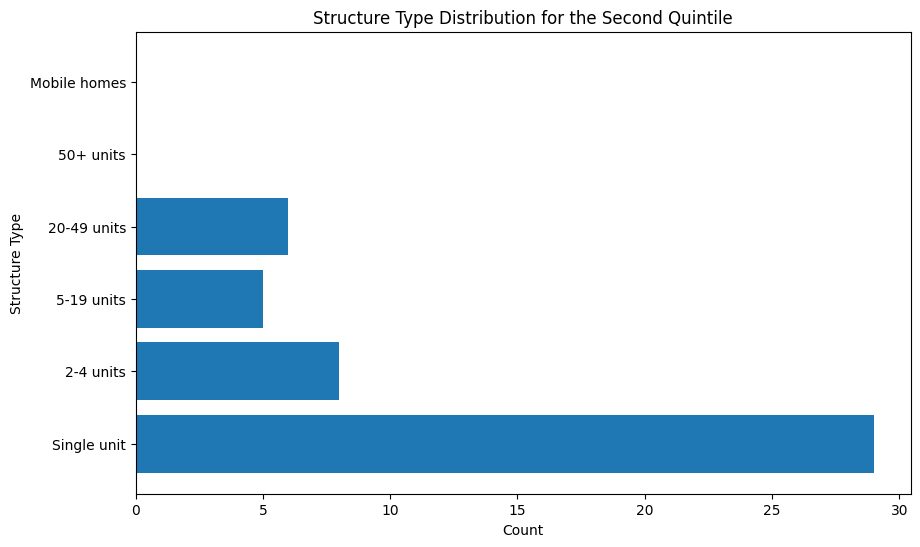

In [ ]:
# Filter the DataFrame for the Second "Quintile"
second_quintile_df = pd_df7[pd_df7['Quintile'] == 'Second']

# Define the structure type labels
structure_type_labels = {
    1: 'Single unit',
    2: '2-4 units',
    3: '5-19 units',
    4: '20-49 units',
    5: '50+ units',
    6: 'Mobile homes'
}

# Count the occurrences of each STRUCTURETYPE within the Second "Quintile"
structure_counts = second_quintile_df['STRUCTURETYPE'].value_counts()

# Create a Series with all possible STRUCTURETYPE values and fill with zeros
all_structure_types = pd.Series(index=range(1, 7), data=0)
all_structure_types.update(structure_counts)  # Update with actual counts

# Create the bar plot
plt.figure(figsize=(10, 6))

# Plotting all possible values 1 to 6 with their corresponding counts
plt.barh(all_structure_types.index, all_structure_types.values, tick_label=[structure_type_labels[i] for i in all_structure_types.index])
plt.xlabel('Count')
plt.ylabel('Structure Type')
plt.title('Structure Type Distribution for the Second Quintile')

plt.show()


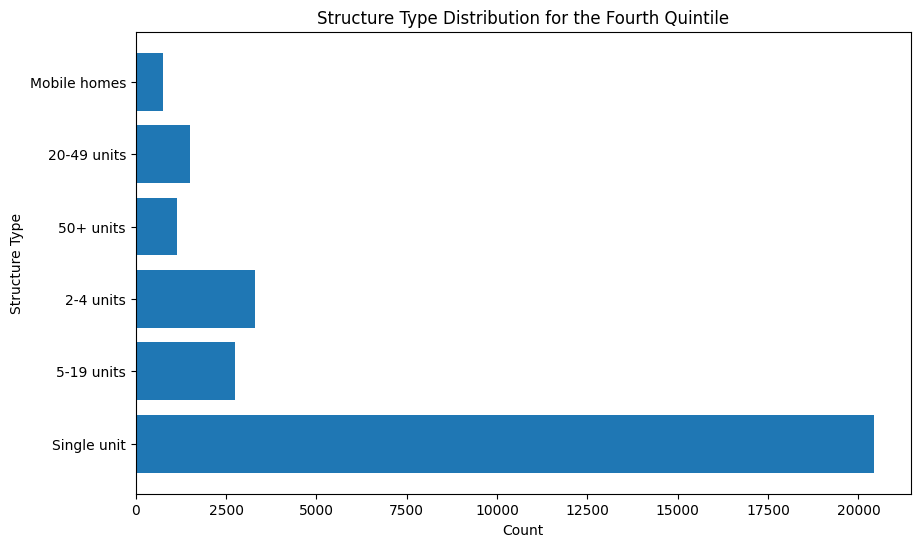

In [ ]:

# Filter the DataFrame for the Fourth "Quintile"
fourth_quintile_df = pd_df7[pd_df7['Quintile'] == 'Fourth']

# Count the occurrences of each STRUCTURETYPE within the Fourth "Quintile"
structure_counts = fourth_quintile_df['STRUCTURETYPE'].value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.barh(structure_counts.index, structure_counts.values, tick_label=[structure_type_labels[i] for i in all_structure_types.index])
plt.xlabel('Count')
plt.ylabel('Structure Type')
plt.title('Structure Type Distribution for the Fourth Quintile')
plt.show()


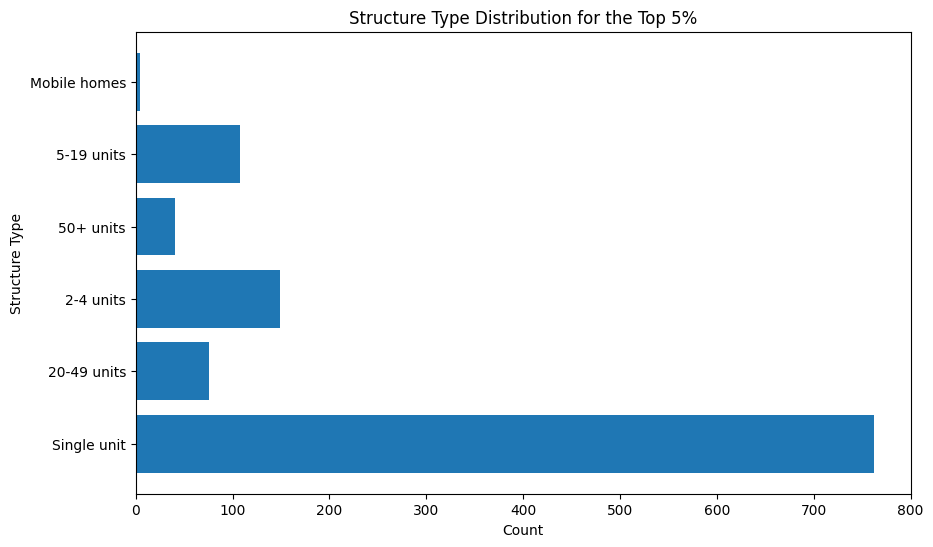

In [ ]:
# Filter the DataFrame for the Fourth "Quintile"
top5_quintile_df = pd_df7[pd_df7['Quintile'] == 'Top 5%']

# Count the occurrences of each STRUCTURETYPE within the Top 5% "Quintile"
structure_counts = top5_quintile_df['STRUCTURETYPE'].value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.barh(structure_counts.index, structure_counts.values, tick_label=[structure_type_labels[i] for i in all_structure_types.index])
plt.xlabel('Count')
plt.ylabel('Structure Type')
plt.title('Structure Type Distribution for the Top 5%')
plt.show()


Analysis

<font color="lightgreen"><h1>8. In each region, what is the most popular type of structure? </h1></font>

Since 1950, the United States Census Bureau defines four statistical regions, with nine divisions.The Census Bureau region definition is "widely used for data collection and analysis", and is the most commonly used classification system. [Wikipedia](https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States)

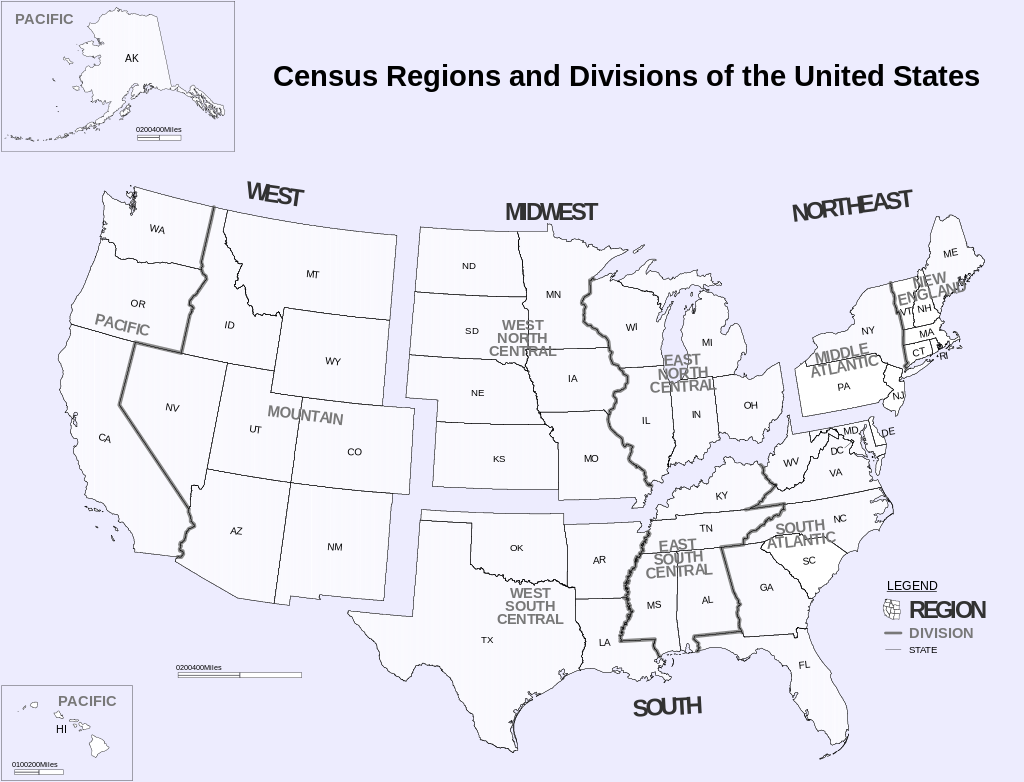

- Region 1 - **Northeast** (massachuset, rhode island, etc)
- Region 2 - **Midwest** (michigan, ohio, nebraska)
- Region 3 - **South** (Washington DC, texas)
- Region 4 - **West** (california, arizona)

> Variables
  - Location = REGION
  - Home structure = STRUCTURETYPE

In [ ]:
df8 = df['REGION', 'STRUCTURETYPE']
df8.describe().show()

+-------+------+------------------+
|summary|REGION|     STRUCTURETYPE|
+-------+------+------------------+
|  count| 49068|             49068|
|   mean|  null| 1.819821472242602|
| stddev|  null|1.4424372779554488|
|    min|   '1'|                -9|
|    max|   '4'|                 6|
+-------+------+------------------+



In [ ]:
df8 = df8.filter(df7['STRUCTURETYPE']>0)
df8.describe().show()
pd_df8 = df8.toPandas()

+-------+------+------------------+
|summary|REGION|     STRUCTURETYPE|
+-------+------+------------------+
|  count| 49060|             49060|
|   mean|  null|1.8215858132898493|
| stddev|  null| 1.435921734985718|
|    min|   '1'|                 1|
|    max|   '4'|                 6|
+-------+------+------------------+



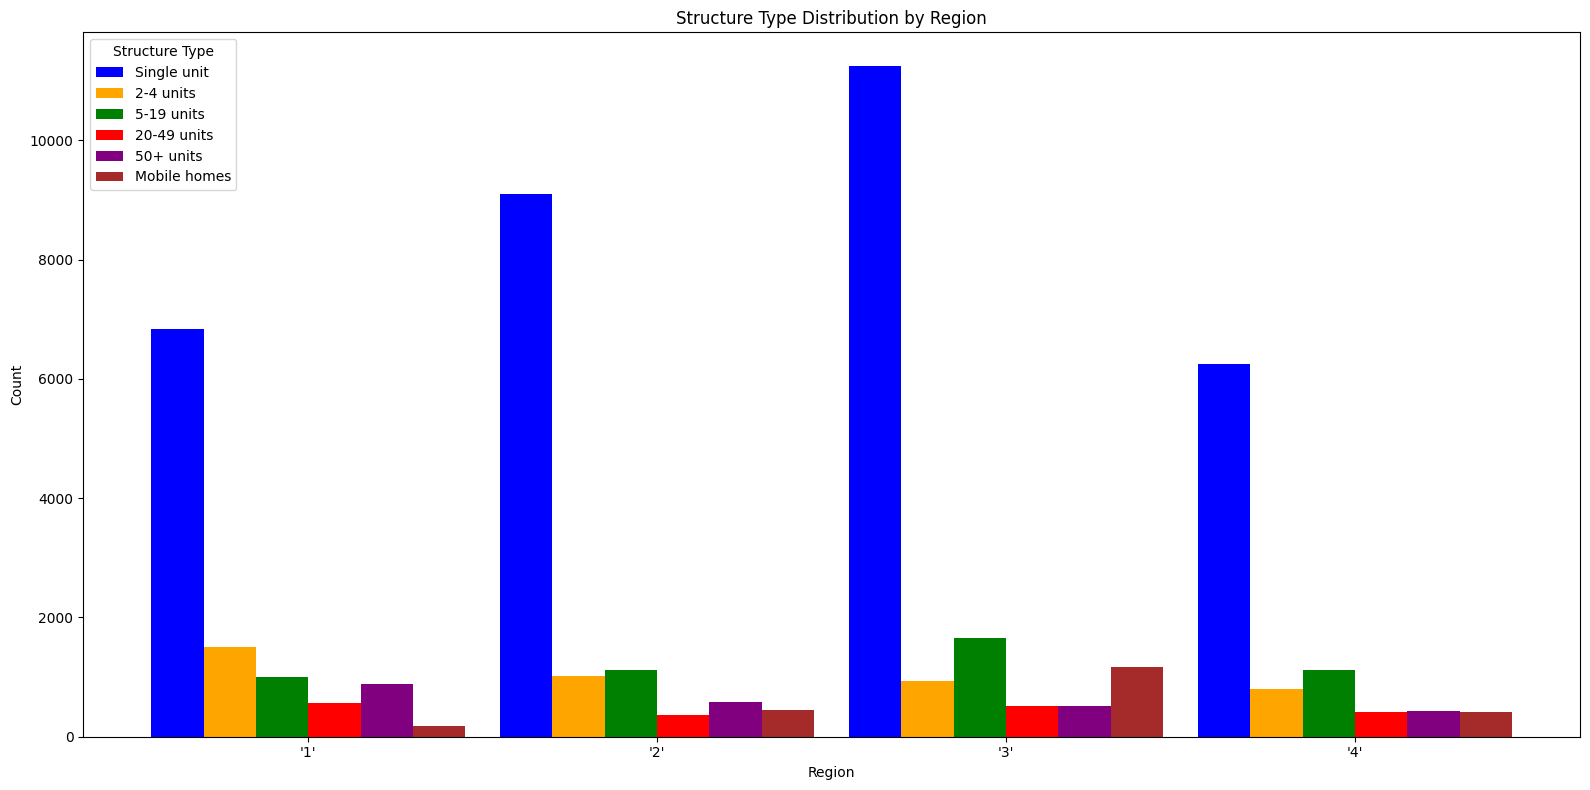

In [ ]:

# Define the structure type labels and colors
structure_type_labels = {
    1: 'Single unit',
    2: '2-4 units',
    3: '5-19 units',
    4: '20-49 units',
    5: '50+ units',
    6: 'Mobile homes'
}

structure_type_colors = {
    1: 'blue',
    2: 'orange',
    3: 'green',
    4: 'red',
    5: 'purple',
    6: 'brown'
}

# Group the DataFrame by REGION and STRUCTURETYPE, and count occurrences
grouped = pd_df8.groupby(['REGION', 'STRUCTURETYPE']).size().reset_index(name='COUNT')

# Get unique regions and structure types
unique_regions = grouped['REGION'].unique()
unique_structure_types = grouped['STRUCTURETYPE'].unique()

# Create the main plot
plt.figure(figsize=(16, 8))

# Iterate through each structure type and plot grouped bars for each region
for i, st in enumerate(unique_structure_types):
    structure_data = grouped[grouped['STRUCTURETYPE'] == st]
    counts = structure_data['COUNT']
    x = np.arange(len(unique_regions)) + i * 0.15
    plt.bar(x, counts, width=0.15, color=structure_type_colors[st], label=structure_type_labels[st])

# Set labels, title, and legend
plt.xlabel('Region')
plt.ylabel('Count')
plt.title('Structure Type Distribution by Region')
plt.xticks(np.arange(len(unique_regions)) + (len(unique_structure_types) - 1) * 0.15 / 2, unique_regions)
plt.legend(title='Structure Type', loc='upper left')

plt.tight_layout()
plt.show()


The majority of homes are single unit which is not surprising considering the US is wide and big so they would much prefer single unit homes.

In this context, the high number of multi-unit buildings in Region 1 aligns with the concentration of densely populated areas. Metropolises like New York City within this region are famously known for their towering apartment buildings that  utilize available space to house a significant number of residents.

<font color="lightgreen"><h1>9. Do region correspond to the market value of the unit, based on the number of rooms in the unit?</h1></font>

> Variables
  - Location = REGION
  - Market Value of a unit = VALUE
  - Number of rooms in a unit = NUNITS

In [ ]:
df9 = df[['REGION', 'VALUE', 'NUNITS']]
df9.describe().show()

+-------+------+-----------------+------------------+
|summary|REGION|            VALUE|            NUNITS|
+-------+------+-----------------+------------------+
|  count| 49068|            49068|             49068|
|   mean|  null|158074.6332029021|10.844542267873155|
| stddev|  null|250180.8188612107| 44.15603237738782|
|    min|   '1'|               -6|                -7|
|    max|   '4'|          2465647|               981|
+-------+------+-----------------+------------------+



In [ ]:
df9 = df9.filter(df9['VALUE'] > 0)
df9 = df9.filter(df9['NUNITS'] > 0)

df9.describe().show()

+-------+------+------------------+------------------+
|summary|REGION|             VALUE|            NUNITS|
+-------+------+------------------+------------------+
|  count| 31477|             31477|             31477|
|   mean|  null|246418.38955427773|3.4509641960796773|
| stddev|  null| 275317.3265830988|24.718178699429878|
|    min|   '1'|                 1|                 1|
|    max|   '4'|           2465647|               981|
+-------+------+------------------+------------------+



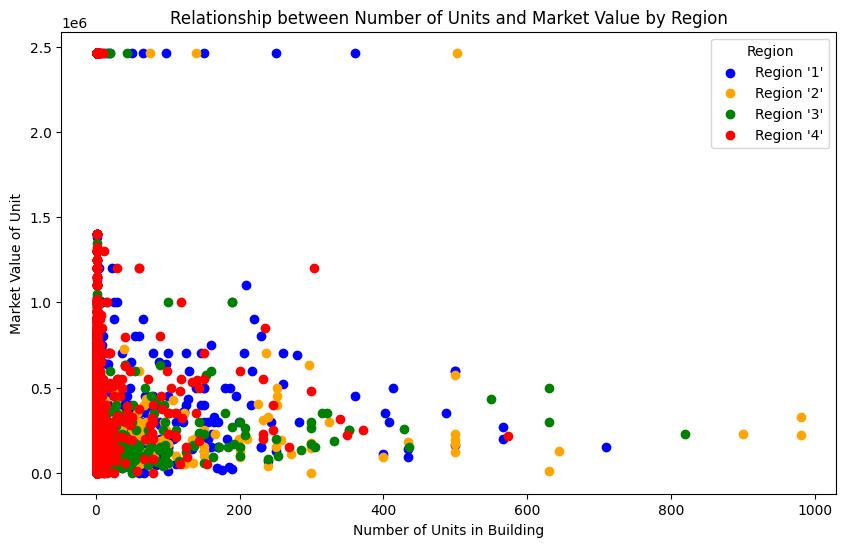

In [ ]:
pd_df9 = df9.toPandas()

# Define colors for each region
region_colors = {
    "'1'": 'blue',
    "'2'": 'orange',
    "'3'": 'green',
    "'4'": 'red'
}

# Create the scatter plot
plt.figure(figsize=(10, 6))

for region, color in region_colors.items():
    region_subset = pd_df9[pd_df9['REGION'] == region]
    plt.scatter(region_subset['NUNITS'], region_subset['VALUE'], color=color, label=f'Region {region}')

# Set labels, title, and legend
plt.xlabel('Number of Units in Building')
plt.ylabel('Market Value of Unit')
plt.title('Relationship between Number of Units and Market Value by Region')
plt.legend(title='Region')

plt.show()


<font color="lightgreen"><h1>10. Are people segregated by the status of their income?</h1></font>

Do rich people only live with other rich people and poor people only lives with poor people?

> Variables
  - Income = Quintile & ZINC2
  - Median income of an area = LMED

In [ ]:
df10 = df[['LMED', 'ZINC2', 'AGE1']]

df10 = df10.filter(df10['LMED'] > 0)
df10 = df10.filter(df10['ZINC2'] > 0)

df10.describe().show()

+-------+------------------+-----------------+------------------+
|summary|              LMED|            ZINC2|              AGE1|
+-------+------------------+-----------------+------------------+
|  count|             44284|            44284|             44284|
|   mean| 66768.09703278837| 66996.3812663716|51.030756029265646|
| stddev|11998.300086330291|68426.17762646428| 17.23329424953238|
|    min|             32000|                1|                14|
|    max|            122300|           852840|                93|
+-------+------------------+-----------------+------------------+



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Define the income ranges
income_ranges = [0, 20034, 38549, 61800, 100000, 180001, float('inf')]
income_range_labels = ['Lowest', 'Second', 'Middle', 'Fourth', 'Top 5%']

# Use the 'withColumn' function to add a new column with income ranges
df10 = df10.withColumn(
    'Quintile',
    when((col('ZINC2') >= income_ranges[0]) & (col('ZINC2') < income_ranges[1]), income_range_labels[0])
    .when((col('ZINC2') >= income_ranges[1]) & (col('ZINC2') < income_ranges[2]), income_range_labels[1])
    .when((col('ZINC2') >= income_ranges[2]) & (col('ZINC2') < income_ranges[3]), income_range_labels[2])
    .when((col('ZINC2') >= income_ranges[3]) & (col('ZINC2') < income_ranges[4]), income_range_labels[3])
    .when(col('ZINC2') >= income_ranges[4], income_range_labels[4])
    .otherwise('Unknown')
)

df10.describe().show()

+-------+------------------+-----------------+------------------+--------+
|summary|              LMED|            ZINC2|              AGE1|Quintile|
+-------+------------------+-----------------+------------------+--------+
|  count|             44284|            44284|             44284|   44284|
|   mean| 66768.09703278837| 66996.3812663716|51.030756029265646|    null|
| stddev|11998.300086330291|68426.17762646428| 17.23329424953238|    null|
|    min|             32000|                1|                14|  Fourth|
|    max|            122300|           852840|                93|  Top 5%|
+-------+------------------+-----------------+------------------+--------+



In [ ]:
pd_df10 = df10.toPandas()

In [ ]:
# Find the unique values in the Quintile column
unique_quintiles = df10.select('Quintile').distinct()
unique_quintiles.show()

+--------+
|Quintile|
+--------+
|  Fourth|
|  Middle|
|  Second|
|  Lowest|
|  Top 5%|
+--------+



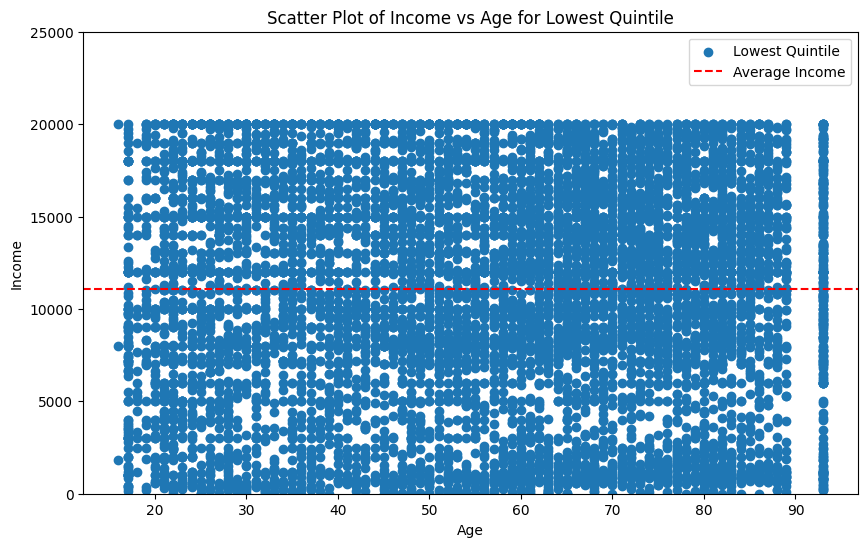

In [ ]:
# Filter the DataFrame for 'Lowest' quintile
lowest_quintile_df = pd_df10[pd_df10['Quintile'] == 'Lowest']

# Calculate the average LMED
average_income = lowest_quintile_df['ZINC2'].mean()

# Create the scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot for 'Lowest' quintile
plt.scatter(lowest_quintile_df['AGE1'], lowest_quintile_df['ZINC2'], label='Lowest Quintile')

# Line for average LMED
plt.axhline(y=average_income, color='red', linestyle='--', label='Average Income')

# Set labels, title, and legend
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Scatter Plot of Income vs Age for Lowest Quintile')
plt.legend()

# Set y-axis limits
plt.ylim(0, 25000)

plt.show()


 Scatter Plot of Income vs. Age for the Lowest Quintile appears relatively uniform. This uniformity could be due to the fact that individuals within the lowest quintile tend to have more consistent income and age demographics, resulting in less variation in the data points.

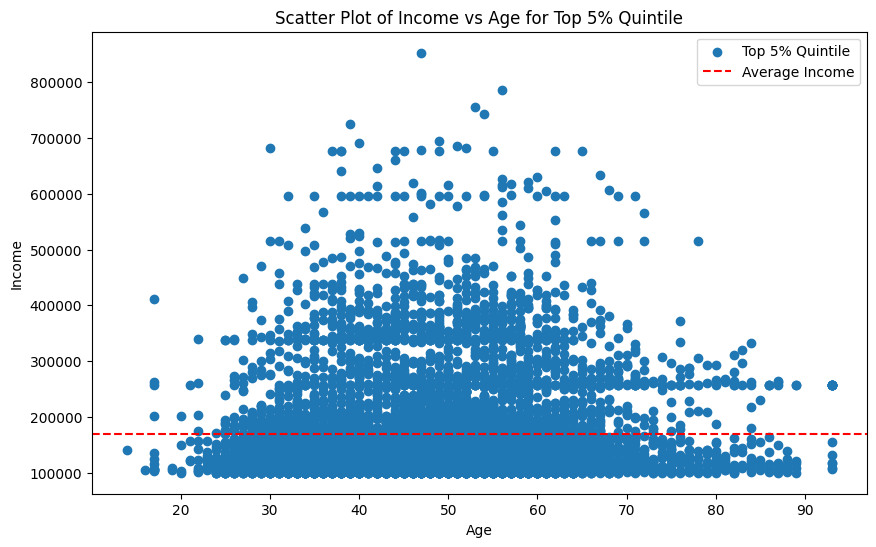

In [ ]:

top5_quintile_df = pd_df10[pd_df10['Quintile'] == 'Top 5%']

# Calculate the average LMED
average_income = top5_quintile_df['ZINC2'].mean()

# Create the scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot for 'Lowest' quintile
plt.scatter(top5_quintile_df['AGE1'], top5_quintile_df['ZINC2'], label='Top 5% Quintile')

# Line for average LMED
plt.axhline(y=average_income, color='red', linestyle='--', label='Average Income')

# Set labels, title, and legend
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Scatter Plot of Income vs Age for Top 5% Quintile')
plt.legend()

# Set y-axis limits
#plt.ylim(0, 25000)

plt.show()


This shows that for the top 5%, the income ranges are so wide that 800k income-person can live with 100k income-person.


A wide income range within the top 5% quintile, which can indeed result in individuals with significantly different income levels falling within the same category. This variation could be due to various factors, such as differences in household composition, location, or other socio-economic factors